In [1]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# device list에 GPU있나 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5546877014437417274
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7799308288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5076778611591004608
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
#라이브러리 설치
!pip install transformers
!pip install keras==2.6

!pip install scikit-learn

#필요한 모듈 불러오기
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, utils

# attention mask 시각화를 위한 모듈
from bertviz import model_view
utils.logging.set_verbosity_error()


from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [4]:
# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
url='./data/service_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,en_ParkChaletGardenRestaurant_477778210:3,When I got there I sat up stairs where the atm...,service,0
1,en_MercedesRestaurant_478010603:4,Can get busy on Fridays for a table but once s...,service,1
2,3511,"A gentleman, maybe the manager, came to our ta...",service,0
3,2846,"Not only was the food outstanding, but the lit...",service,1
4,en_SchoonerOrLater_477965850:7,A brief conversation with the manager at the e...,service,0


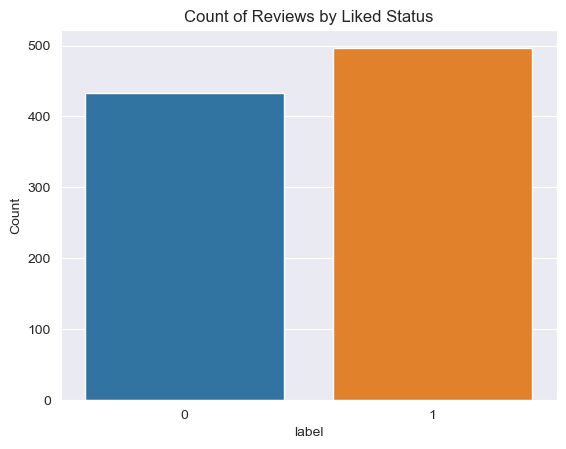

In [36]:
# review data의 label 분포
sns.set_style('darkgrid')

# Create a count plot of the "Liked" column
sns.countplot(x='polarity', data=df)

# Set the title of the plot
plt.title('Count of Reviews by Liked Status')

# Set the label for the x-axis
plt.xlabel('label')

# Set the label for the y-axis
plt.ylabel('Count')

# Show the plot
plt.show()

In [5]:
count_neg = len(df[df['polarity'] == 0])
count_pos=len(df[df['polarity'] == 1])
print("positive: {}, negative: {}".format(count_pos,count_neg))

positive: 497, negative: 433


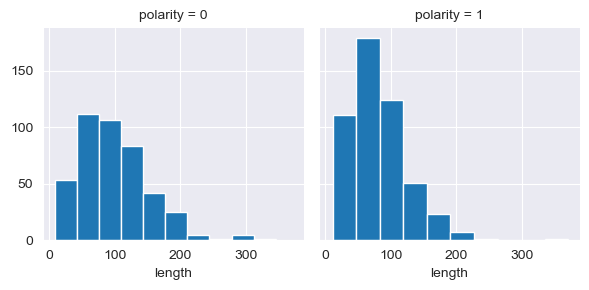

In [6]:
# review data의 길이 분포 및 통계
df_new=df
df_new['length'] = df['text'].apply(len)

# Create a FacetGrid object with 'Liked' as the column to be used for separating the data
# FacetGrid is a grid of subplots that displays the same relationship between different subsets of your data.
g = sns.FacetGrid(df, col='polarity')

# Use the FacetGrid object to plot a histogram of the 'Length' column for each value of 'Liked'
g.map(plt.hist, 'length');

In [7]:
df_new.length.describe()

count    930.000000
mean      90.240860
std       49.354521
min        9.000000
25%       54.000000
50%       82.000000
75%      116.750000
max      370.000000
Name: length, dtype: float64

In [6]:
text = df.text.values
labels = df.polarity.values

In [7]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [8]:
# 토큰마다 ID가 어떻게 부여되는지 보자
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ they     │        2027 │
├──────────┼─────────────┤
│ forgot   │        9471 │
├──────────┼─────────────┤
│ a        │        1037 │
├──────────┼─────────────┤
│ sandwich │       11642 │
├──────────┼─────────────┤
│ ,        │        1010 │
├──────────┼─────────────┤
│ didn     │        2134 │
├──────────┼─────────────┤
│ '        │        1005 │
├──────────┼─────────────┤
│ t        │        1056 │
├──────────┼─────────────┤
│ include  │        2421 │
├──────────┼─────────────┤
│ plastic  │        6081 │
├──────────┼─────────────┤
│ forks    │       19896 │
├──────────┼─────────────┤
│ ,        │        1010 │
├──────────┼─────────────┤
│ and      │        1998 │
├──────────┼─────────────┤
│ didn     │        2134 │
├──────────┼─────────────┤
│ '        │        1005 │
├──────────┼─────────────┤
│ t        │        1056 │
├──────────┼─────────────┤
│ include  │        2421 │
├──────────┼─────────────┤
│

In [9]:
MAX_LENGTH=150
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [55]:
token_id[6]

tensor([  101,  1045,  2001,  2471, 11770,  2011,  1996,  2755,  2008,  2016,
         2001,  3810,  2185,  6304,  2012,  1023,  9737,  2006,  1037,  5958,
         2305,  2138,  2016,  1000,  2018,  1037, 22861,  4160,  2000,  2175,
         2000,  1000,  2008,  2305,  1011,  1059, 24475,  1029,  1029,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [14]:
# 토큰 ID와 attention mask가 잘 추출 되었는지 보자
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒═════════════╤═════════════╤══════════════════╕
│ Tokens      │   Token IDs │   Attention Mask │
╞═════════════╪═════════════╪══════════════════╡
│ [CLS]       │         101 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ service     │        2326 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ was         │        2001 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ awful       │        9643 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ -           │        1011 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ mostly      │        3262 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ because     │        2138 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ staff       │        3095 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ were        │        2020 │                1 │
├─────────────┼─────

In [10]:
VAL_RATIO= 0.2
batch_size = 8 # 16 or 32 추천이라고 한다

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 744
validation: 186


In [11]:

def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [12]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = True,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
# GPU로 학습하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 횟수 설정
epochs = 15

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))
    #print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    #print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    #print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:   7%|█████                                                                       | 1/15 [00:07<01:48,  7.74s/it]


	 - Train loss: 0.4225
	 - Validation Accuracy: 0.8750


Epoch:  13%|██████████▏                                                                 | 2/15 [00:14<01:33,  7.17s/it]


	 - Train loss: 0.1672
	 - Validation Accuracy: 0.9062


Epoch:  20%|███████████████▏                                                            | 3/15 [00:21<01:23,  7.00s/it]


	 - Train loss: 0.1219
	 - Validation Accuracy: 0.8750


Epoch:  27%|████████████████████▎                                                       | 4/15 [00:28<01:16,  6.92s/it]


	 - Train loss: 0.1098
	 - Validation Accuracy: 0.9167


Epoch:  33%|█████████████████████████▎                                                  | 5/15 [00:34<01:08,  6.89s/it]


	 - Train loss: 0.0182
	 - Validation Accuracy: 0.9219


Epoch:  40%|██████████████████████████████▍                                             | 6/15 [00:41<01:01,  6.88s/it]


	 - Train loss: 0.0015
	 - Validation Accuracy: 0.9219


Epoch:  47%|███████████████████████████████████▍                                        | 7/15 [00:48<00:54,  6.87s/it]


	 - Train loss: 0.0006
	 - Validation Accuracy: 0.9219


Epoch:  53%|████████████████████████████████████████▌                                   | 8/15 [00:55<00:48,  6.86s/it]


	 - Train loss: 0.0004
	 - Validation Accuracy: 0.9219


Epoch:  60%|█████████████████████████████████████████████▌                              | 9/15 [01:02<00:41,  6.86s/it]


	 - Train loss: 0.0180
	 - Validation Accuracy: 0.9010


Epoch:  67%|██████████████████████████████████████████████████                         | 10/15 [01:09<00:34,  6.91s/it]


	 - Train loss: 0.0736
	 - Validation Accuracy: 0.8958


Epoch:  73%|██████████████████████████████████████████████████████▉                    | 11/15 [01:16<00:27,  6.90s/it]


	 - Train loss: 0.0405
	 - Validation Accuracy: 0.9219


Epoch:  80%|████████████████████████████████████████████████████████████               | 12/15 [01:23<00:20,  6.90s/it]


	 - Train loss: 0.0745
	 - Validation Accuracy: 0.9115


Epoch:  87%|█████████████████████████████████████████████████████████████████          | 13/15 [01:30<00:13,  6.89s/it]


	 - Train loss: 0.0570
	 - Validation Accuracy: 0.8750


Epoch:  93%|██████████████████████████████████████████████████████████████████████     | 14/15 [01:36<00:06,  6.89s/it]


	 - Train loss: 0.0389
	 - Validation Accuracy: 0.9115


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 15/15 [01:43<00:00,  6.92s/it]


	 - Train loss: 0.0236
	 - Validation Accuracy: 0.9219


In [18]:
print(epo_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [19]:
print(train_loss_list)

[0.4375, 0.1637, 0.0797, 0.0627, 0.0293, 0.0059, 0.0224, 0.0345, 0.0058, 0.0004]


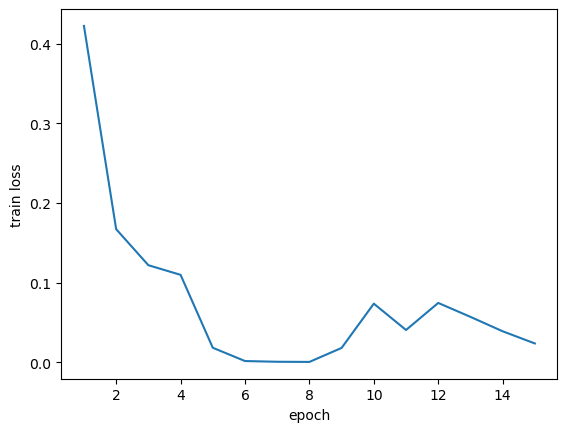

In [14]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

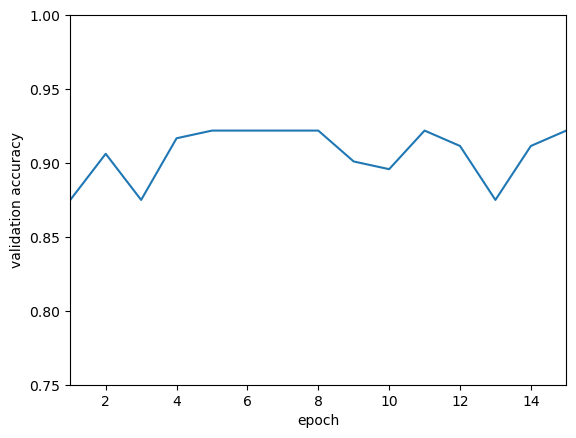

In [15]:
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [16]:
#새로운 리뷰를 분류해보자

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='food was delicious, but the staff was so rude.'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'





print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: food was delicious, but the staff was so rude.
분류: Negative


In [17]:
#test data 세팅

# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/service_test.csv'
df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
df.head(5)


,id,text,polarity
0,33068635#1533725#2,The food is very good and the service is great.,1
1,35820984#608922#3,The staff is very sharp and they look good too.,1
2,11351819#985076#2,Waiting three hours before getting our entrees...,0
3,en_MiopostoCaffe_478542919:5,"Finally, my wife stood face to face in front o...",0
4,en_MiopostoCaffe_478542919:4,We stood there for 10 minutes while employees ...,0


In [18]:
count_neg = len(df[df['polarity'] == 0])
count_pos=len(df[df['polarity'] == 1])
print("positive: {}, negative: {}".format(count_pos,count_neg))

positive: 52, negative: 48


In [19]:
count=0

test_text = df.text.values
test_labels = df.polarity.values

wrongResult=[]
rightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        rightResult.append(t)
    else:
        wrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
    

=============================== Input 1 ===============================
The food is very good and the service is great.
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
The staff is very sharp and they look good too.
model result: Positive 
answer: 1 

=============================== Input 3 ===============================
Waiting three hours before getting our entrees was a treat as well.
model result: Positive 
answer: 0 

=============================== Input 4 ===============================
Finally, my wife stood face to face in front of one of the staff and she asked, "Are you waiting for a table?"
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
We stood there for 10 minutes while employees walked back and forth ignoring us.
model result: Negative 
answer: 0 

=============================== Input 6 ===============================
The service is pretty good.
mode

=============================== Input 46 ===============================
The appetizers are ok, but the service is slow.
model result: Negative 
answer: 0 

=============================== Input 47 ===============================
I HAVE NEVER HAD A BAD MEAL(OR BAD SERVICE )@ PIGALLE.
model result: Negative 
answer: 1 

=============================== Input 48 ===============================
Tiny restaurant with very fast service.
model result: Positive 
answer: 1 

=============================== Input 49 ===============================
The bartenders and the managers are really nice and the decor is very comfy and laid-back, all the while being trendy.
model result: Positive 
answer: 1 

=============================== Input 50 ===============================
Service was kind of slow, our waitress took forever to give us our check even though it wasn't that busy.
model result: Negative 
answer: 0 

=============================== Input 51 ===============================
The food was m

In [22]:
print(wrongResult)

['Waiting three hours before getting our entrees was a treat as well.', 'Service is known for bending over backwards to make everyone happy.', 'I HAVE NEVER HAD A BAD MEAL(OR BAD SERVICE )@ PIGALLE.', "If I want to stand in line on Sunday for an hour to get average brunch food, then I would put Murphy's at the top of the list."]


In [20]:
# 개별 문장의 attention 추출하는 함수
def get_attention(encoding):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        model_output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
        
    prediction = 'Positive' if np.argmax(model_output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    attention=model_output[-1]
    last_attention=attention[-1]
    tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    return attention,last_attention,tokens,prediction

In [21]:
def get_val_len(ids):
    count=0
    for elem in ids:
        if(elem!=0):
            count+=1
    return count

In [22]:
# 개별 문장의 attention 추출
from bertviz import head_view

sent="Terrible service, but cheap and reasonable price."

# 전처리
encoding = preprocessing(sent, tokenizer,10)


retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

print('입력 문장:', sent)
print('분류:', prediction)
print()

head_view(retAtt,retTok)


입력 문장: Terrible service, but cheap and reasonable price.
분류: Negative



<IPython.core.display.Javascript object>

In [23]:
def sort_by_att(attention,tokens):
    '''
        last layer의 attention tensor를 입력 받아 각 token의 attention 값을 head에 대한 평균을 낸 뒤, attention이 높은 token 순으로 idx를 반환하는 함수
    '''
    
    attention=attention[0] # shape: 12,len,len
    
    size=len(tokens)
    
    total_atts_sum=[] # 각 head에 대한 각 토큰의 attention값의 합
    for head in range(0,12):
        att_of_head=attention[head] # 한 head의 attention
        atts_sum_of_head=[0.0]*size # 해당 head 하나의 attention의 합
        for row in att_of_head:
            col=0
            for elem in row:
                value=elem.item()
                atts_sum_of_head[col]+=value # head 하나에 대한 토큰이 가지는 attention 값
                col+=1
        total_atts_sum.append(atts_sum_of_head)
    
    total_sum_value=[0.0]*size
    for elem in total_atts_sum:
        for i in range(0,size):
            total_sum_value[i]+=elem[i]
            

    total_mean=[]
    for elem in total_sum_value:
        total_mean.append(elem/12)
    
    


    idxs=sorted(range(len(total_mean)), key=lambda k: total_mean[k], reverse=True)
    return(idxs)
    

In [24]:
# attention 순서대로 텍스트 배경색 주기
color_code=[
    "\033[48;5;243m",
    "\033[48;5;245m",
    "\033[48;5;247m",
    "\033[48;5;249m",
    "\033[48;5;251m",
    "\033[48;5;253m",
    "\033[48;5;255m"
]
def emp_by_att(attIdxs,tokens):   
    valTokens=[]
    for tok in tokens:
        if(tok!='[CLS]' and tok!='[PAD]' and tok!='[SEP]'):
            valTokens.append(tok)
        
    valIdxs=[]
    for idx in attIdxs:
        if len(valIdxs)==7:
            break;
        
        if(idx>0 and idx<=len(valTokens)):
            if(valTokens[idx-1]!=',' and valTokens[idx-1]!='.'):
                valIdxs.append(idx-1)
    
    resultSent=""
    for i in range(len(valTokens)):
        if(i in valIdxs):
            outTok=color_code[valIdxs.index(i)]+valTokens[i]+"\033[0m"
        else:
            outTok=valTokens[i]
        resultSent+=outTok
        resultSent+=' '
    
    print("========================= emphasize by attention result==========================")
    print(resultSent)

In [25]:
def get_highest_att_tok(idxs,retTok,num):
    count=0
    print("highest attention: ",end="")
    for i in idxs:
        if(i<len(retTok)):
            if(retTok[i]!='[CLS]' and retTok[i]!='[SEP]' and retTok[i]!='.' and retTok[i]!=','):
                if(count<num):
                    print(retTok[i],end=" ")
                    count+=1
                

In [26]:
# 개별 문장을 attention이 높은 token 순으로 보여주기
idxs=sort_by_att(retLastAtt,retTok)

emp_by_att(idxs,retTok)

get_highest_att_tok(idxs,retTok,3)

========================= emphasize by attention result==========================
terrible service , but cheap and reasonable price 
highest attention: cheap terrible and 

In [27]:
#잘못 분류된 문장의 attention
for sent in wrongResult:
    encoding = preprocessing(sent, tokenizer,50)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: Waiting three hours before getting our entrees was a treat as well.
분류: Positive
MAX_LEN:  17
========================= emphasize by attention result==========================
waiting three hours before getting our en ##tree ##s was a treat as well . 
highest attention: was well getting as 



입력 문장: the food was great, the margaritas too but the waitress was too busy being nice to her other larger party than to take better care of my friend and me.
분류: Positive
MAX_LEN:  35
========================= emphasize by attention result==========================
the food was great , the margarita ##s too but the waitress was too busy being nice to her other larger party than to take better care of my friend and me . 
highest attention: but busy was was 



입력 문장: I HAVE NEVER HAD A BAD MEAL(OR BAD SERVICE )@ PIGALLE.
분류: Negative
MAX_LEN:  18
========================= emphasize by attention result==========================
i have never had a bad meal ( or bad service ) @ pig ##alle . 


In [28]:
#NAVER test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_service_test.csv'
df = pd.read_csv(test_url,sep=',', header=0,encoding="CP949")
df.head(5)

,id,category,text,polarity,trans_text
0,1546,service,직원이 친절하지 않습니다. \n음식이 조금 짠 편이고 가격대비는 글쎄요…,0,The staff is not friendly. The food is a littl...
1,101,service,언제나처럼 맛 그대로고 직원분들 친절하시고\n오래간만에 어린이 김밥과 쫄면 포장 잘...,1,"As always, the taste is the same and the staff..."
2,1543,service,오래전부터 단골이었는데\n가격 올리면서 고기양은 줄어들고 퀄리티는 낮아졌습니다. 직...,0,I've been a regular for a long time. As the pr...
3,88,service,음... 정말 맛있네요.\n김밥 정말 깔끔하고 맛있어요.\n야채도 듬뿍 넣어주시고요...,1,"Well, it's really good.. Kimbap is very clean ..."
4,155,service,야미야미 들리셔스 했습니다! 매장 청결 하고 매우 친절 하시고 맛도 있어요 근처 사...,1,"Yummy, yummy. I heard it! The store is clean, ..."


In [29]:
# naver data에 대한 분류 및 accuracy 측정
count=0

test_text = df.trans_text.values
test_labels = df.polarity.values

NaverWrongResult=[]
NaverRightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].trans_text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        NaverRightResult.append(t)
    else:
        NaverWrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))

=============================== Input 1 ===============================
The staff is not friendly. The food is a little salty and I don't know about the price…
model result: Negative 
answer: 0 

=============================== Input 2 ===============================
As always, the taste is the same and the staff are kind. It's been a long time since I packed children's gimbap and jjolmyeon well.Good luck!
model result: Positive 
answer: 1 

=============================== Input 3 ===============================
I've been a regular for a long time. As the price increased, the amount of meat decreased and the quality decreased. The employees are not very good-natured either. The service is the worst.  I won't visit again.
model result: Negative 
answer: 0 

=============================== Input 4 ===============================
Well, it's really good.. Kimbap is very clean and delicious.. Please add lots of vegetables.. Nice and quick response. Good
model result: Positive 
answer: 1 

=

=============================== Input 46 ===============================
I think it's an Indian couple, but they're kind and generous
model result: Positive 
answer: 1 

=============================== Input 47 ===============================
He's always so kind, so I use it often It's my first time trying lemonade and it's really good   It makes me want to visit often
model result: Positive 
answer: 1 

=============================== Input 48 ===============================
I'm not that kind
model result: Negative 
answer: 0 

=============================== Input 49 ===============================
It's good, but the staff is so unfriendly
model result: Negative 
answer: 0 

=============================== Input 50 ===============================
The store is really messy.. Sprite was carbonated water without any sweetness.. There seemed to be a shortage of staff.
model result: Negative 
answer: 0 

=============================== Input 51 ===============================
He's kind an

In [30]:
#잘못 분류된 문장의 attention
for sent in NaverWrongResult:
    encoding = preprocessing(sent, tokenizer,70)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: It's too unkind and expensive for the food level.. It's a place where there's always waiting, so there's nothing to be sad about, so my nose bridge is too high
분류: Positive
MAX_LEN:  45
========================= emphasize by attention result==========================
it ' s too un ##kind and expensive for the food level . . it ' s a place where there ' s always waiting , so there ' s nothing to be sad about , so my nose bridge is too high 
highest attention: ' ' and so 



입력 문장: It's unkind. It's good
분류: Positive
MAX_LEN:  12
========================= emphasize by attention result==========================
it ' s un ##kind . it ' s good 
highest attention: ' good s un 



입력 문장: The dessert is good, but the cashier is unkind
분류: Positive
MAX_LEN:  14
========================= emphasize by attention result==========================
the dessert is good , but the cash ##ier is un ##kind 
highest attention: but ##kind un good 



입력 문장: I had ox knee soup and it's clean and delici

In [31]:
#잘 분류된 문장의 attention
for sent in NaverRightResult:
    encoding = preprocessing(sent, tokenizer,70)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: The staff is not friendly. The food is a little salty and I don't know about the price…
분류: Negative
MAX_LEN:  24
========================= emphasize by attention result==========================
the staff is not friendly . the food is a little salty and i don ' t know about the price … 
highest attention: ' not little is 



입력 문장: As always, the taste is the same and the staff are kind. It's been a long time since I packed children's gimbap and jjolmyeon well.Good luck!
분류: Positive
MAX_LEN:  42
========================= emphasize by attention result==========================
as always , the taste is the same and the staff are kind . it ' s been a long time since i packed children ' s gi ##mba ##p and jj ##ol ##my ##eon well . good luck ! 
highest attention: ' and ! staff 



입력 문장: I've been a regular for a long time. As the price increased, the amount of meat decreased and the quality decreased. The employees are not very good-natured either. The service is the worst.  I won

========================= emphasize by attention result==========================
sweet pumpkin soup tastes good , but it ' s not kind 
highest attention: good not tastes sweet 



입력 문장: It tastes good.. . I don't know if it's just us, but... There was a bad smell on the table.. . I want you to pay attention to cleaning the table.
분류: Negative
MAX_LEN:  46
========================= emphasize by attention result==========================
it tastes good . . . i don ' t know if it ' s just us , but . . . there was a bad smell on the table . . . i want you to pay attention to cleaning the table . 
highest attention: ' bad want good 



입력 문장: It's so nice. I want to come again. He's so kind. The menu is good, too. Thank you.
분류: Positive
MAX_LEN:  30
========================= emphasize by attention result==========================
it ' s so nice . i want to come again . he ' s so kind . the menu is good , too . thank you . 
highest attention: ' ' he good 



입력 문장: He's kind and the food 

========================= emphasize by attention result==========================
there are many delicious wa ##ffle ##s and cr ##off ##les these days , so the taste is normal compared to my ##ung ##sun ##g ( ) . there ' s no place to sit and eat , and it ' s not kind . 
highest attention: many and no so 



입력 문장: Kalguksu Dumpling Bibim is all delicious Of course, the price is higher than other places, but there is meat garnish and I think it's good to have a refill, but the staff is unfriendly
분류: Negative
MAX_LEN:  54
========================= emphasize by attention result==========================
ka ##l ##gu ##ks ##u dump ##ling bi ##bi ##m is all delicious of course , the price is higher than other places , but there is meat ga ##rn ##ish and i think it ' s good to have a ref ##ill , but the staff is un ##fr ##ien ##dly 
highest attention: ' ##dly un ##fr 



입력 문장: I went to lunch with my mother today, and both pork cutlet and char siu over rice were delicious, and above all, t

========================= emphasize by attention result==========================
kim ##ba ##p is delicious and the boss is kind . 
highest attention: and kind is delicious 



입력 문장: It's very delicious and kind..♥
분류: Positive
MAX_LEN:  12
========================= emphasize by attention result==========================
it ' s very delicious and kind . . ♥ 
highest attention: ' and kind delicious 



입력 문장: I came across this place while looking for a brunch restaurant. The interior of the cafe is clean and pretty There are many brunch menus, coffee is delicious, and the owner is kind It's a place where I want to revisit
분류: Positive
MAX_LEN:  55
========================= emphasize by attention result==========================
i came across this place while looking for a br ##un ##ch restaurant . the interior of the cafe is clean and pretty there are many br ##un ##ch menu ##s , coffee is delicious , and the owner is kind it ' s a place where i want to rev ##isi ##t 
highest attentio

========================= emphasize by attention result==========================
the service is still very messy . the male manager is very kind , but it ' s a little messy to see if he ' s catching the system . it ' s nice to get in through the barrel , but there ' s also cigarette smoke . 
highest attention: ' ' ' but 



입력 문장: The bread is so good^^ The owner is kind, too. I'll visit again next time
분류: Positive
MAX_LEN:  23
========================= emphasize by attention result==========================
the bread is so good ^ ^ the owner is kind , too . i ' ll visit again next time 
highest attention: ' is kind too 



입력 문장: He's kind and most importantly, it's delicious Especially rice with shrimp sauce...
분류: Positive
MAX_LEN:  22
========================= emphasize by attention result==========================
he ' s kind and most importantly , it ' s delicious especially rice with shrimp sauce . . . 
highest attention: and kind he s 



입력 문장: I strongly recommend this soon

========================= emphasize by attention result==========================
it doesn ' t taste like before . the soup is salty and the noodles are so ##ggy . the staff ' s service is kind of bad , too . meat is soft and delicious 
highest attention: ' bad ##ggy soft 



입력 문장: Unfriendly. Tasteful
분류: Negative
MAX_LEN:  9
========================= emphasize by attention result==========================
un ##fr ##ien ##dly . taste ##ful 
highest attention: un ##dly ##ful taste 



입력 문장: They are so kind and the bread is so delicious!! It's very affordable and I want to go again(Laughing)
분류: Positive
MAX_LEN:  28
========================= emphasize by attention result==========================
they are so kind and the bread is so delicious ! ! it ' s very affordable and i want to go again ( laughing ) 
highest attention: ' and kind and 



입력 문장: I always feel happy as soon as I take my first bite. The amount is large and the boss is very kind and it can be said to be the best ar